In [521]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as sms

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut, train_test_split

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, \
GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from xgboost import XGBClassifier

from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

# Porter Delivery Time Estimation

### Problem Statement

Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.

Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.

This dataset has the required data to train a regression model that will do the delivery time estimation, based on all those features

### Data Dictionary
Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below:

* market id: integer id for the market where the restaurant lies

* created at: the timestamp at which the order was placed

* actual delivery time: the timestamp when the order was delivered

* Store id: id's of various stores

* store_primary_category: category for the restaurant

* order protocol: integer code value for order protocol(how the order was placed le: through porter, call to restaurant, pre booked, third part etc)

* total items: no of items in the order

* subtotal: final price of the order

* num_distinct items: the number of distinct items in the order

* min_item_price: price of the cheapest item in the order

* max_item_price: price of the costliest item in order

* total_onshift_partners: number of delivery partners on duty at the time order was placed

* total_busy_partners: number of delivery partners attending to other tasks

* total outstanding_orders: total number of orders to be fulfilled at the moment

In [433]:
data= pd.read_csv('dataset.csv')
data.head(10)

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26   
5        3.0  2015-01-28 20:30:38  2015-01-28 21:08:58   
6        3.0  2015-01-31 02:16:36  2015-01-31 02:43:00   
7        3.0  2015-02-12 03:03:35  2015-02-12 03:36:20   
8        2.0  2015-02-16 00:11:35  2015-02-16 00:38:01   
9        3.0  2015-02-18 01:15:45  2015-02-18 02:08:57   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
3  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
4  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
5  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
6  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
7  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
8  f0ade77b43923b38237db569b016ba25                 indian             3.0   
9  f0ade77b43923b38237db569b016ba25                    NaN             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            1      1900                   1            1900            1900   
3            6      6900                   5             600            1800   
4            3      3900                   3            1100            1600   
5            3      5000                   3            1500            1900   
6            2      3900                   2            1200            2700   
7            4      4850                   4             750            1800   
8            4      4771                   3             820            1604   
9            2      2100                   2             700            1200   

   total_onshift_partners  total_busy_partners  total_outstanding_orders  
0                    33.0                 14.0                      21.0  
1                     1.0                  2.0                       2.0  
2                     1.0                  0.0                       0.0  
3                     1.0                  1.0                       2.0  
4                     6.0                  6.0                       9.0  
5                     2.0                  2.0                       2.0  
6                    10.0                  9.0                       9.0  
7                     7.0                  8.0                       7.0  
8                     8.0                  6.0                      18.0  
9                     2.0                  2.0                       2.0

In [434]:
print('Rows:', data.shape[0])
print('Columns:', data.shape[1])

Rows: 197428
Columns: 14


In [435]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [436]:
data.isnull().sum()

market_id                     987
created_at                      0
actual_delivery_time            7
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
dtype: int64

In [437]:
data.describe()

market_id  order_protocol    total_items       subtotal  \
count  196441.000000   196433.000000  197428.000000  197428.000000   
mean        2.978706        2.882352       3.196391    2682.331402   
std         1.524867        1.503771       2.666546    1823.093688   
min         1.000000        1.000000       1.000000       0.000000   
25%         2.000000        1.000000       2.000000    1400.000000   
50%         3.000000        3.000000       3.000000    2200.000000   
75%         4.000000        4.000000       4.000000    3395.000000   
max         6.000000        7.000000     411.000000   27100.000000   

       num_distinct_items  min_item_price  max_item_price  \
count       197428.000000   197428.000000   197428.000000   
mean             2.670791      686.218470     1159.588630   
std              1.630255      522.038648      558.411377   
min              1.000000      -86.000000        0.000000   
25%              1.000000      299.000000      800.000000   
50%              2.000000      595.000000     1095.000000   
75%              3.000000      949.000000     1395.000000   
max             20.000000    14700.000000    14700.000000   

       total_onshift_partners  total_busy_partners  total_outstanding_orders  
count           181166.000000        181166.000000             181166.000000  
mean                44.808093            41.739747                 58.050065  
std                 34.526783            32.145733                 52.661830  
min                 -4.000000            -5.000000                 -6.000000  
25%                 17.000000            15.000000                 17.000000  
50%                 37.000000            34.000000                 41.000000  
75%                 65.000000            62.000000                 85.000000  
max                171.000000           154.000000                285.000000

In [438]:
data.describe(include= 'object')

created_at actual_delivery_time  \
count                197428               197421   
unique               180985               178110   
top     2015-02-11 19:50:43  2015-02-11 20:40:45   
freq                      6                    5   

                                store_id store_primary_category  
count                             197428                 192668  
unique                              6743                     74  
top     d43ab110ab2489d6b9b2caa394bf920f               american  
freq                                 937                  19399

* `created_at` and `actual_delivery_time` are in object format, they need to be converted to datetime formats.
* `market_id`,  `actual_delivery_time`,  `store_primary_category`,  `order_protocol`, `total_onshift_partners`, `total_busy_partners` and `total_outstanding_orders` have missing values that needs to be treated.
* Nearly 75% of the stores are located in 1st ,2nd ,3rd and 4th markets.
* There are 74 unique category of stores out of which american is the most popular one.
* Most people ordered through porter or call to restaurant or pre booked.
* On an average a single order contained 3 items out of which 2 were distinct.
* On an average the minimum price of an item in each order was 595 and the maximum was 1095.
* The average bill amount for all the orders is Rs 2200.

# Feature Engineering

Converting `created_at` and `actual_delivery_time` column to datetime and extracting meaningful columns.

In [439]:
data['created_at']= pd.to_datetime(data['created_at'])

In [440]:
data['actual_delivery_time']= pd.to_datetime(data['actual_delivery_time'])

In [441]:
data['delivery_time']= (data['actual_delivery_time']- data['created_at']).dt.total_seconds()/60

In [442]:
data['delivery_time'].describe()

count    197421.000000
mean         48.470956
std         320.493482
min           1.683333
25%          35.066667
50%          44.333333
75%          56.350000
max      141947.650000
Name: delivery_time, dtype: float64

In [443]:
def func(i):
    if i<=30:
        return ('Fast Delivery')
    elif i<=50:
        return ('Standard Delivery')
    else:
        return ('Slow Delivery')

In [444]:
data['delivery']= data['delivery_time'].apply(func)

In [445]:
data['delivery'].value_counts()

Standard Delivery    99181
Slow Delivery        72271
Fast Delivery        25976
Name: delivery, dtype: int64

In [446]:
data['delivery'].value_counts(normalize=True)

Standard Delivery    0.502365
Slow Delivery        0.366063
Fast Delivery        0.131572
Name: delivery, dtype: float64

**We have created our target variable that explains whether it was quick, fast, slow or very slow delivery:**

Extracting other meaningful columns from the data.

In [447]:
data['order_month']= data['created_at'].dt.month

In [448]:
data['order_day']= data['created_at'].dt.day

In [449]:
data['order_hour']= data['created_at'].dt.hour

<AxesSubplot:xlabel='order_hour', ylabel='count'>

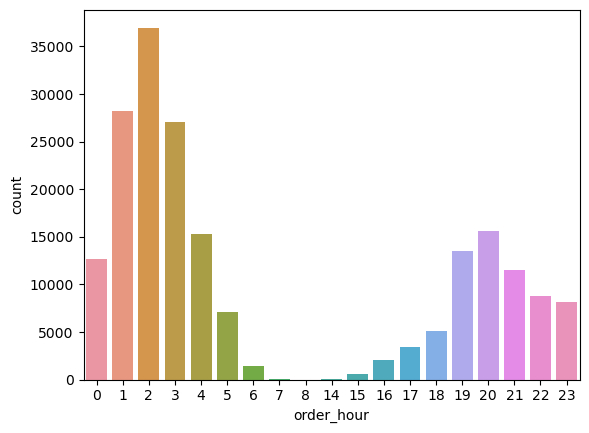

In [450]:
sns.countplot(data['order_hour'])

By looking at the above graph, we can see that the orders were created mostly from 12 to 6 am in the morning and from 6 to 11 pm in the evening, based on this we can derive a new columns which explains the time of the day in which orders were created the most.

In [451]:
def order_time(i):
    if i<=5:
        return 'Late Night'
    elif i<=9:
        return 'Early Morning'
    elif i<=12:
        return 'Morning'
    elif i <=16:
        return 'Afternoon'
    elif i <=20:
        return 'Evening'
    else:
        return 'Night'

In [452]:
data['time_of_the_day']= data['order_hour'].apply(order_time)

In [453]:
data['order_weekday']= data['created_at'].dt.weekday

In [454]:
data['total_free_partners']= (data['total_onshift_partners'] - data['total_busy_partners'])

In [455]:
del data['delivery_time']

In [456]:
del data['created_at']
del data['actual_delivery_time']
del data['store_id']

In [457]:
data.head()

market_id store_primary_category  order_protocol  total_items  subtotal  \
0        1.0               american             1.0            4      3441   
1        2.0                mexican             2.0            1      1900   
2        3.0                    NaN             1.0            1      1900   
3        3.0                    NaN             1.0            6      6900   
4        3.0                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_partners  \
0                   4             557            1239                    33.0   
1                   1            1400            1400                     1.0   
2                   1            1900            1900                     1.0   
3                   5             600            1800                     1.0   
4                   3            1100            1600                     6.0   

   total_busy_partners  total_outstanding_orders           delivery  \
0                 14.0                      21.0      Slow Delivery   
1                  2.0                       2.0      Slow Delivery   
2                  0.0                       0.0      Fast Delivery   
3                  1.0                       2.0      Slow Delivery   
4                  6.0                       9.0  Standard Delivery   

   order_month  order_day  order_hour time_of_the_day  order_weekday  \
0            2          6          22           Night              4   
1            2         10          21           Night              1   
2            1         22          20         Evening              3   
3            2          3          21           Night              1   
4            2         15           2      Late Night              6   

   total_free_partners  
0                 19.0  
1                 -1.0  
2                  1.0  
3                  0.0  
4                  0.0

# Univariate Analysis

In [458]:
numcols= data.select_dtypes(include= np.number).columns
numcols

Index(['market_id', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'order_month', 'order_day', 'order_hour',
       'order_weekday', 'total_free_partners'],
      dtype='object')

In [459]:
num_cols= ['total_items', 'subtotal', 'num_distinct_items','min_item_price','max_item_price','total_onshift_partners',
           'total_busy_partners','total_outstanding_orders', 'total_free_partners']

In [460]:
cat_cols= ['market_id', 'order_protocol', 'store_primary_category', 'order_weekday', 'order_month', 'order_day', 
           'order_hour','time_of_the_day','delivery']  

In [462]:
# We will exclude store_id for now as it is an unrelevant column and its plots will not provide meaningful information.

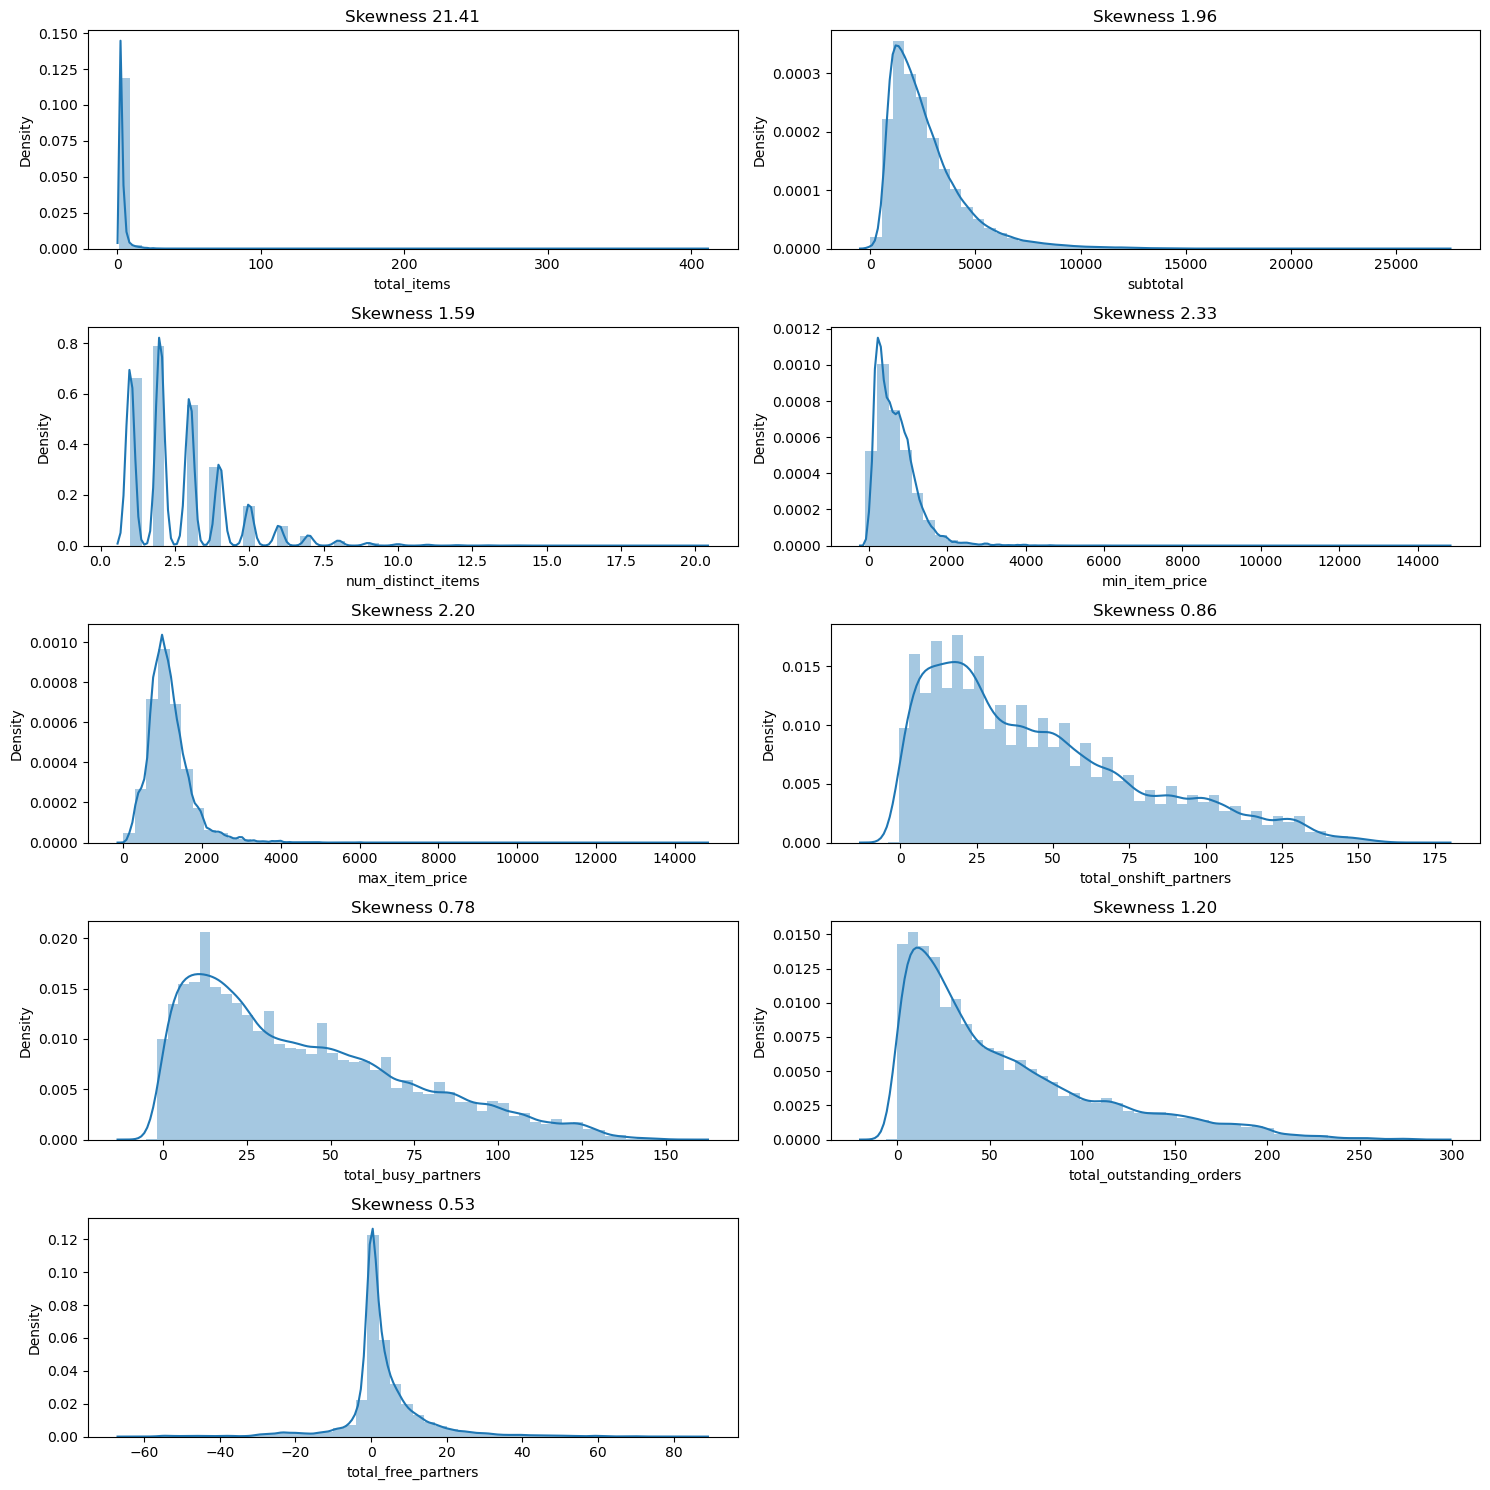

In [463]:
t=1
plt.figure(figsize= (15,15))
for i in num_cols:
    plt.subplot(5,2,t)
    plt.title('Skewness %.2f'%data[i].skew())
    sns.distplot(data[i])
    t+=1
plt.tight_layout()
plt.show()

All the numerical columns are heavily right skewed and `total_free_partners` have outliers on both the ends.

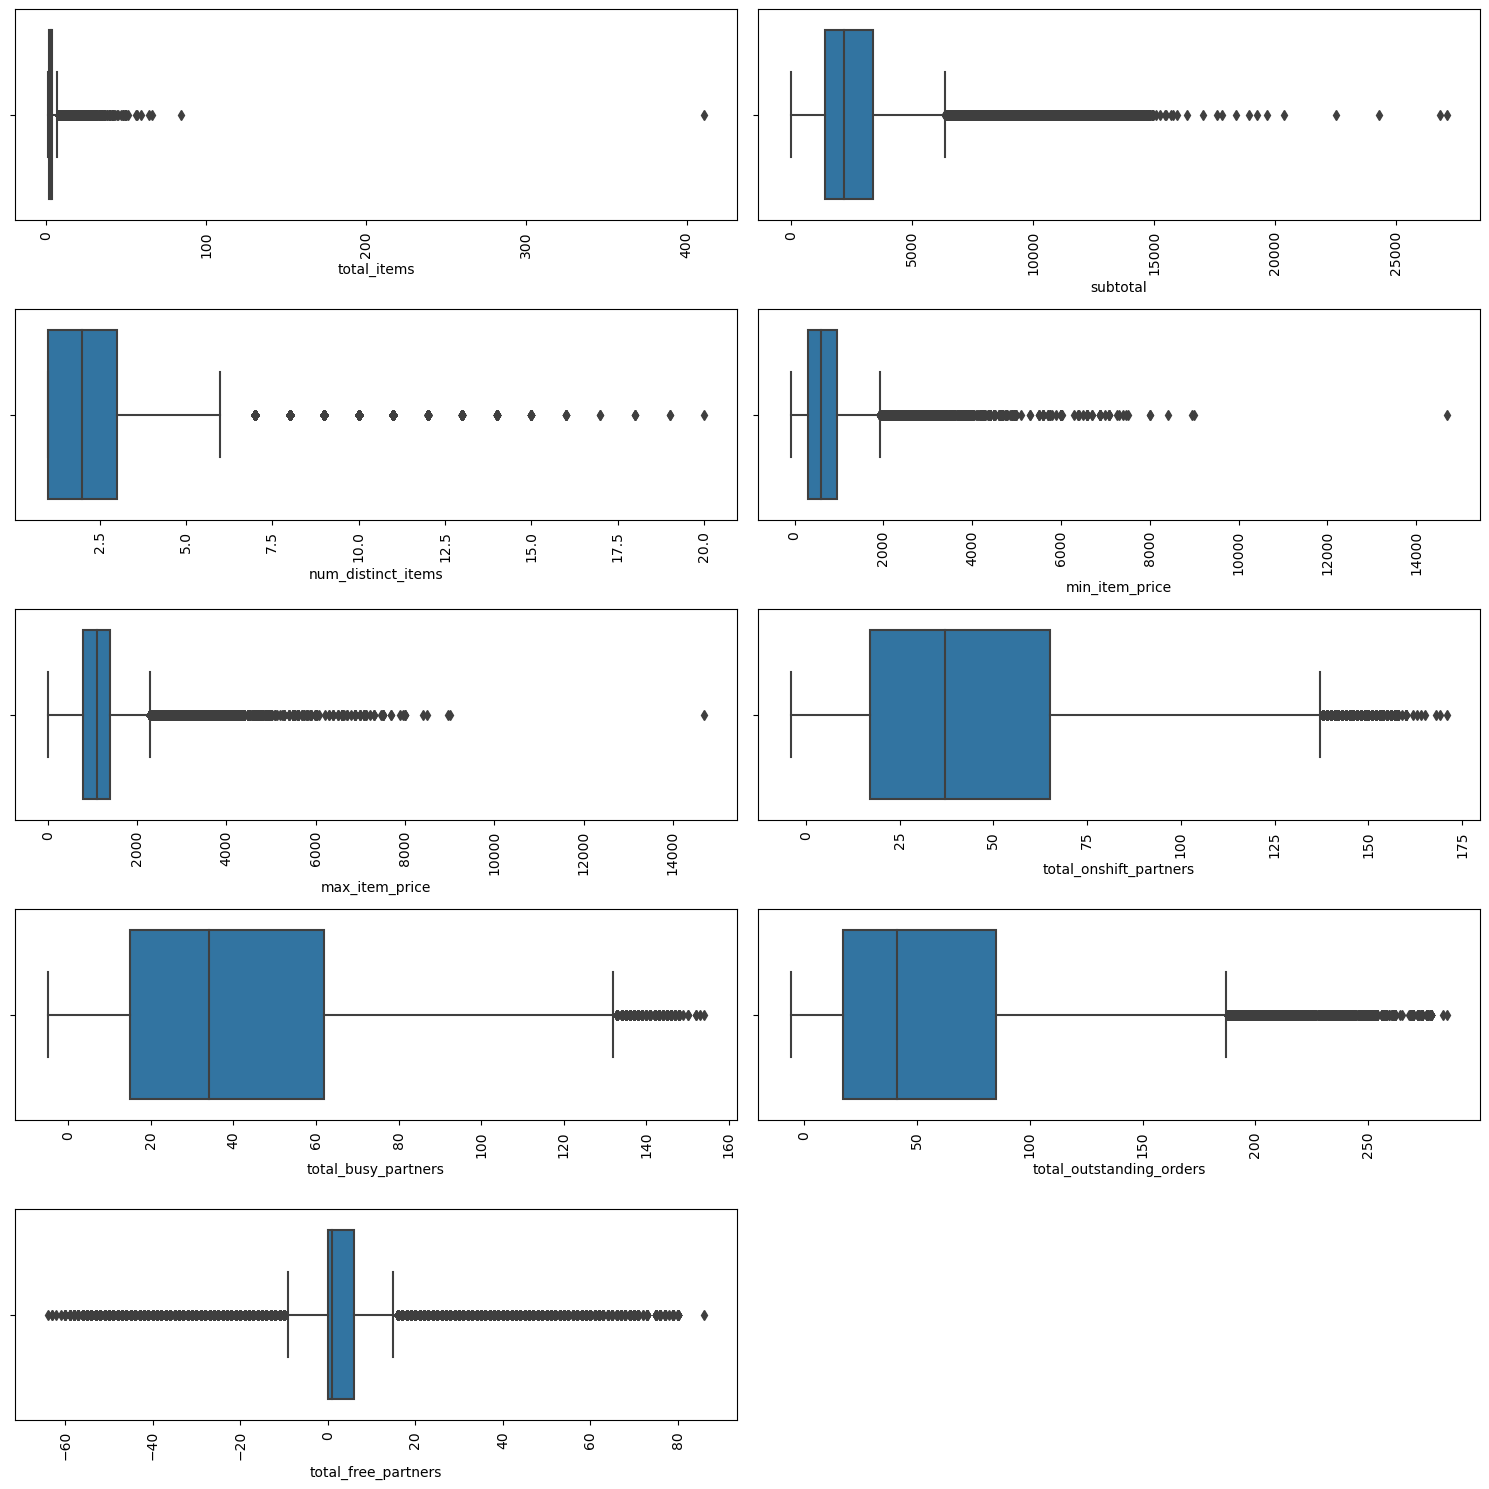

In [464]:
t=1
plt.figure(figsize= (15,15))
for i in num_cols:
    plt.subplot(5,2,t)
    sns.boxplot(data[i])
    plt.xticks(rotation= 90)
    t+=1
plt.tight_layout()
plt.show()

All numerical variables have outliers on the upper side and `total_free_partners` have outliers on the lower end as well.

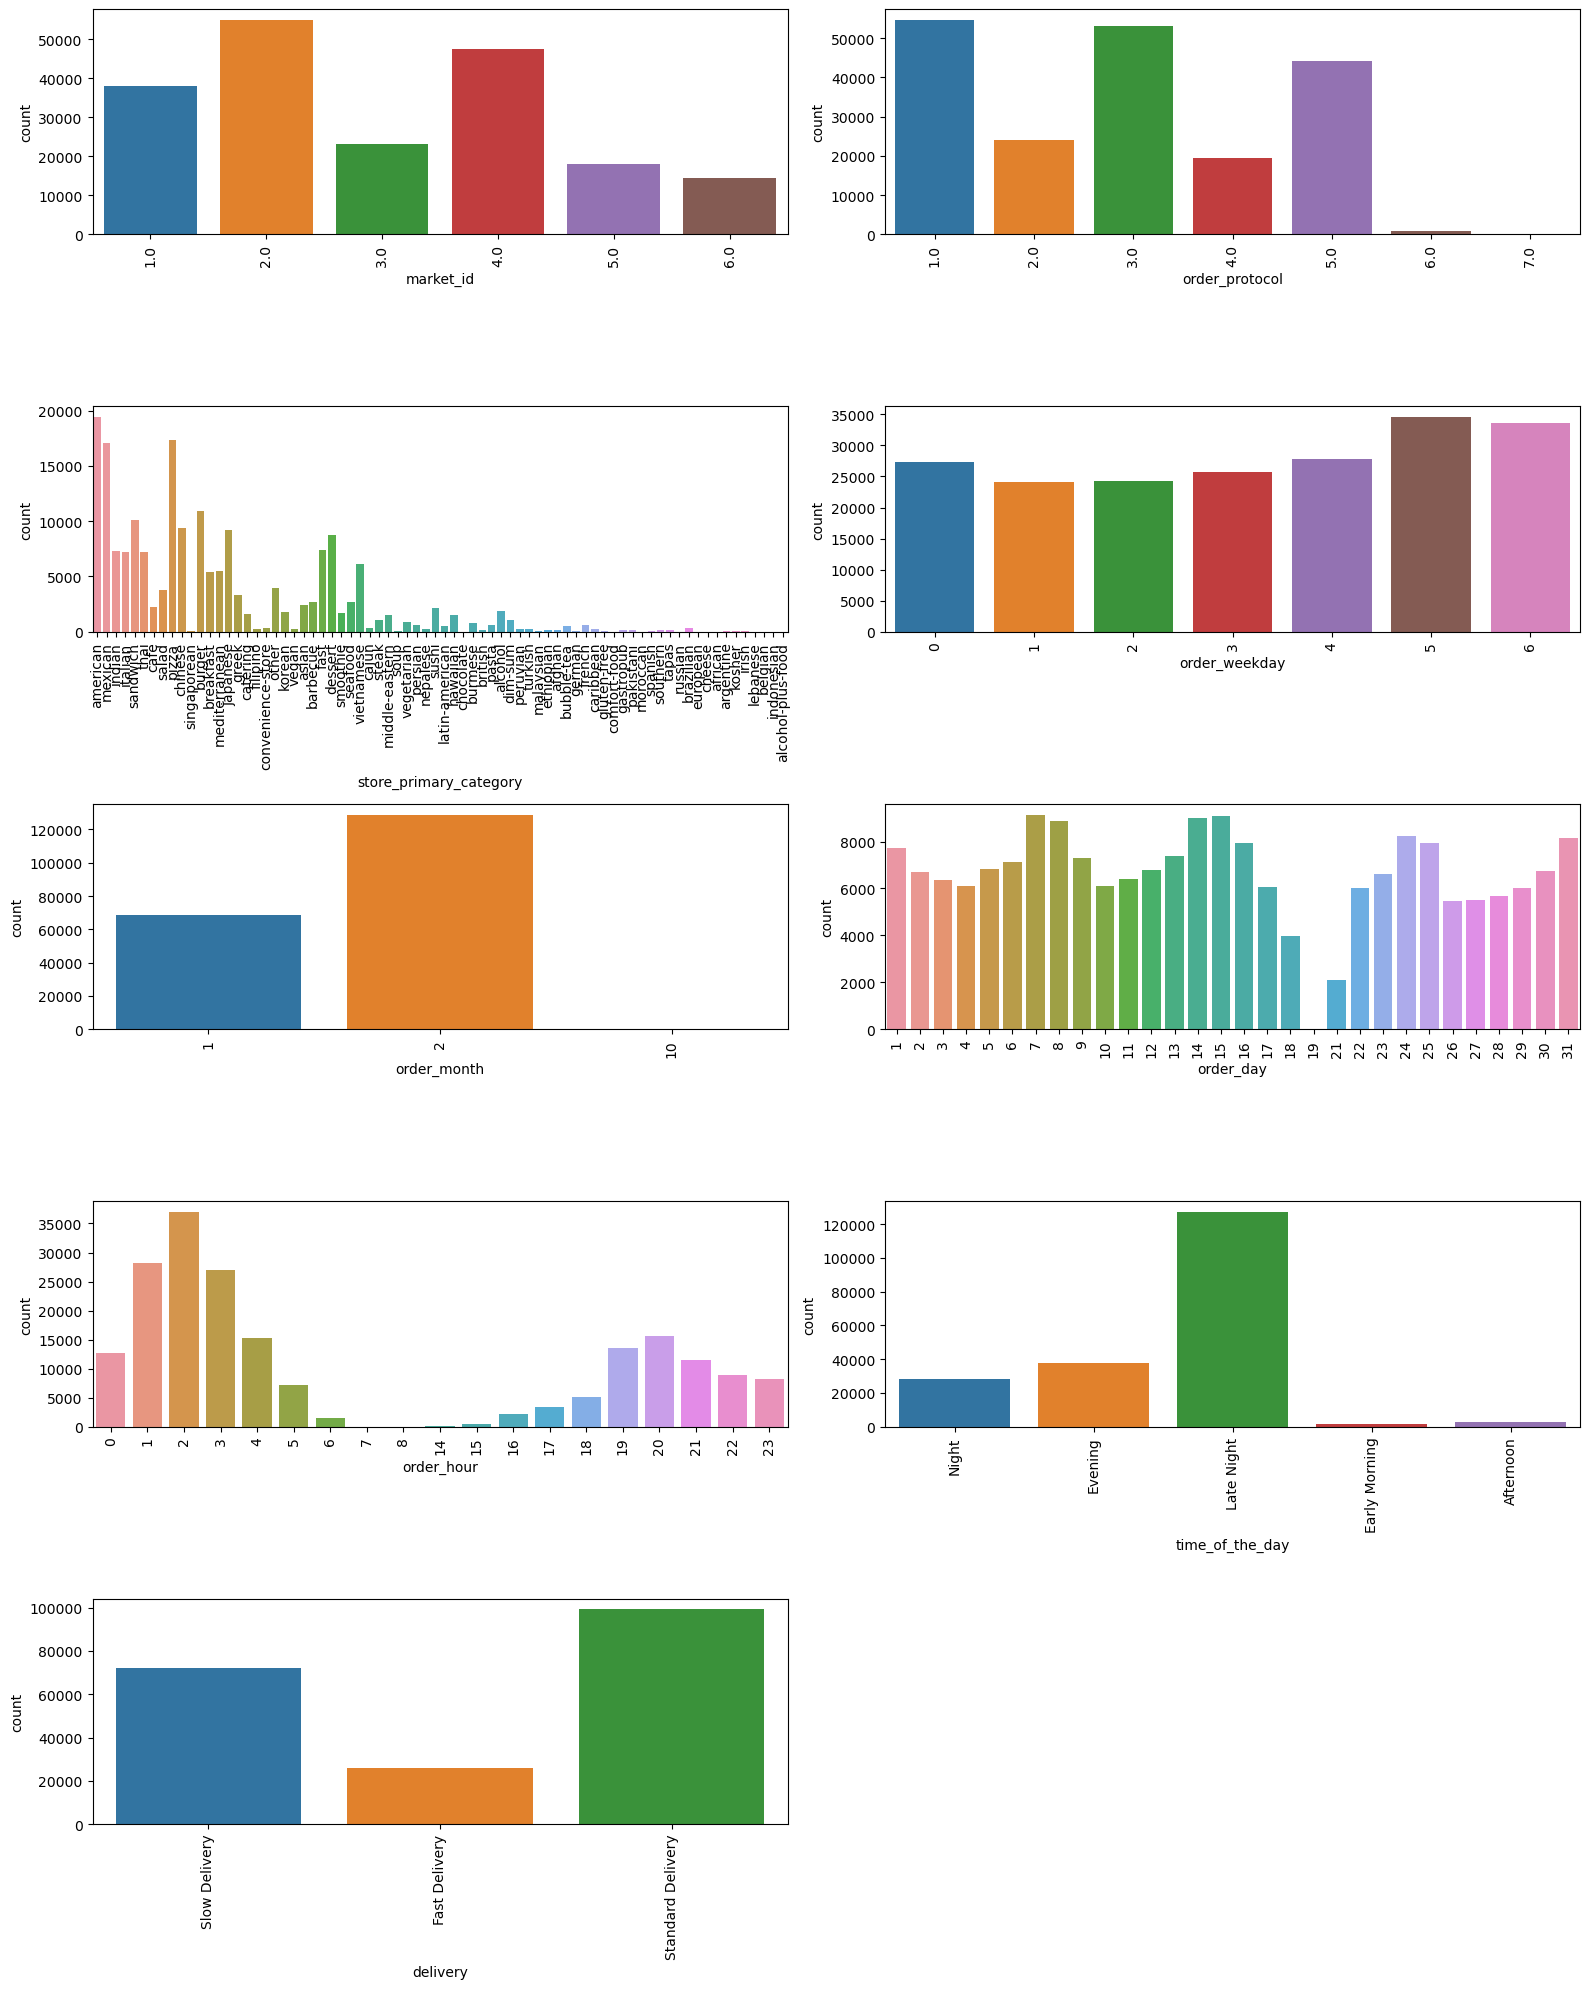

In [465]:
t=1
plt.figure(figsize= (16,20))
for i in cat_cols:
    plt.subplot(5,2,t)
    sns.countplot(data[i])
    plt.xticks(rotation= 90)
    t+=1
plt.tight_layout()
plt.show()

In [466]:
data['market_id'].value_counts(normalize= True)

2.0    0.280278
4.0    0.242307
1.0    0.193631
3.0    0.118595
5.0    0.091631
6.0    0.073559
Name: market_id, dtype: float64

In [467]:
data['order_protocol'].value_counts(normalize= True)

1.0    0.278594
3.0    0.270825
5.0    0.225471
2.0    0.122444
4.0    0.098527
6.0    0.004042
7.0    0.000097
Name: order_protocol, dtype: float64

In [468]:
data['store_primary_category'].value_counts(normalize= True).head(20)

american         0.100686
pizza            0.089901
mexican          0.088749
burger           0.056875
sandwich         0.052214
chinese          0.048898
japanese         0.047730
dessert          0.045534
fast             0.038263
indian           0.037962
thai             0.037500
italian          0.037261
vietnamese       0.031635
mediterranean    0.028609
breakfast        0.028157
other            0.020699
salad            0.019438
greek            0.017263
seafood          0.014169
barbecue         0.014128
Name: store_primary_category, dtype: float64

* Most of the orders were from market id 2, 4 and 1 respectively.
* Maximum orders were booked through porter(1.0) or pre-booked(3.0) or  through (5.0).
* American, pizza  and mexican stores are the top 3 type of stores respectively from which customers ordered the most. 
* The amount of orders on the weekends were alomost 20 to 30k more as compared to the orders on the weekdays.
* The dataset is of the starting months of 2015 in which the maximum orders were made in the second month.
* Restaurents received most orders from 12 to 6 am in the morning and from 6 to 11 pm in the evening.
* 25% of the orders were delivered fast.
* Almost 75% of the orders were delivered after 35 minutes leading to high delivery time.

# Bivariate Analysis

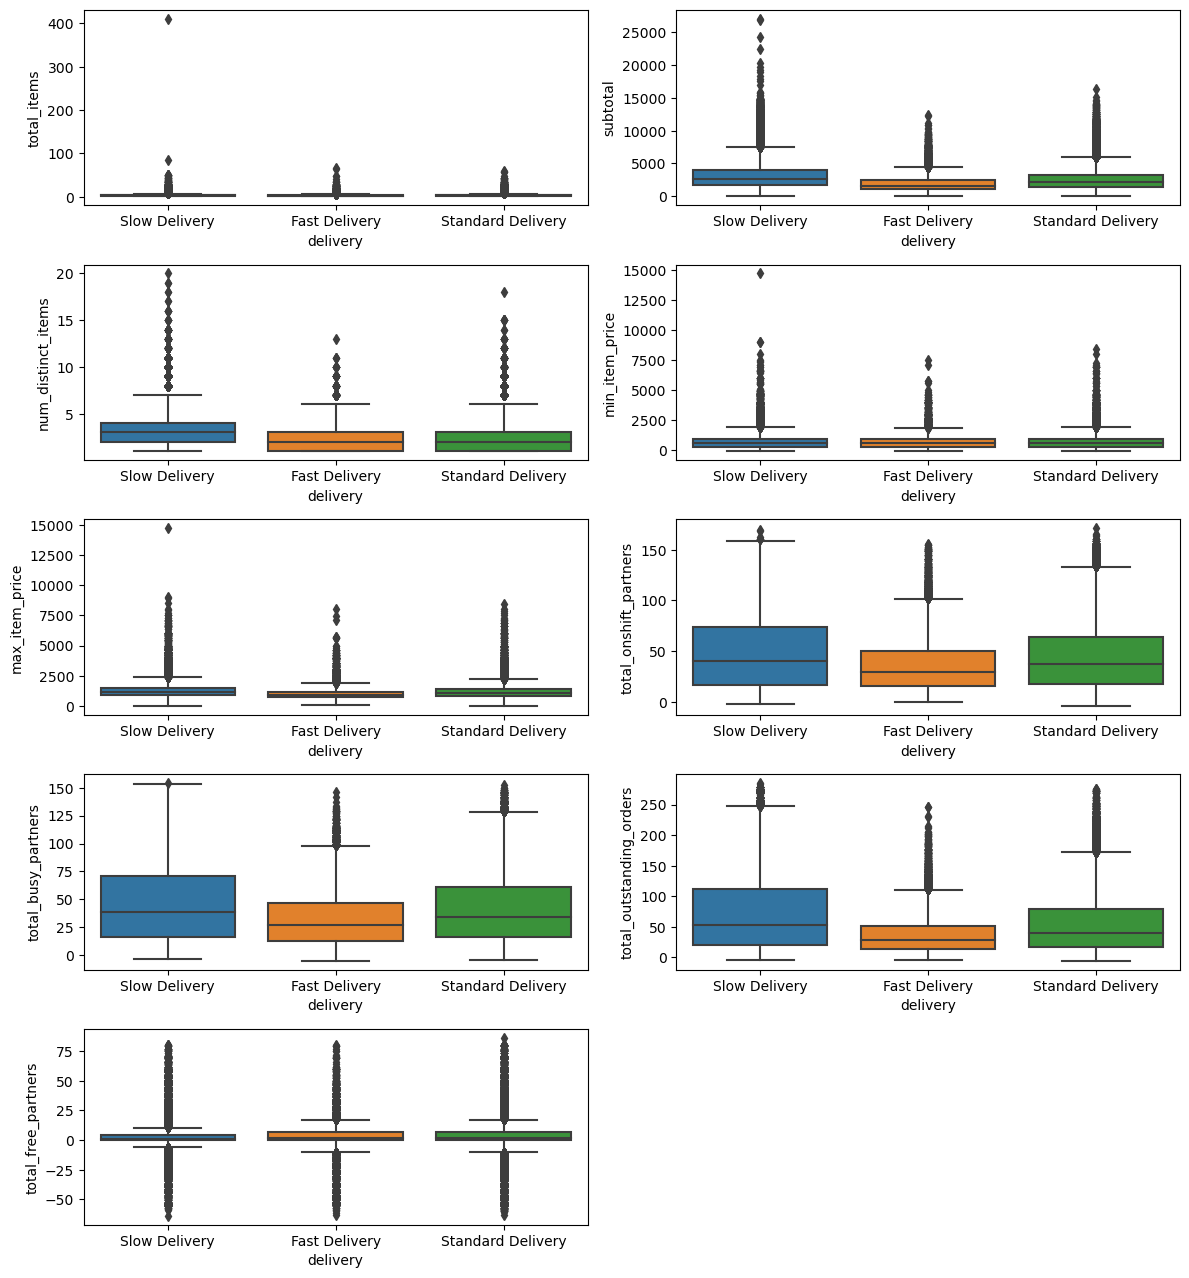

In [473]:
t=1
plt.figure(figsize= (12,15))
for i in num_cols:
    plt.subplot(6,2,t)
    sns.boxplot(y= data[i], x= data['delivery'])
    t+=1
plt.tight_layout()
plt.show()

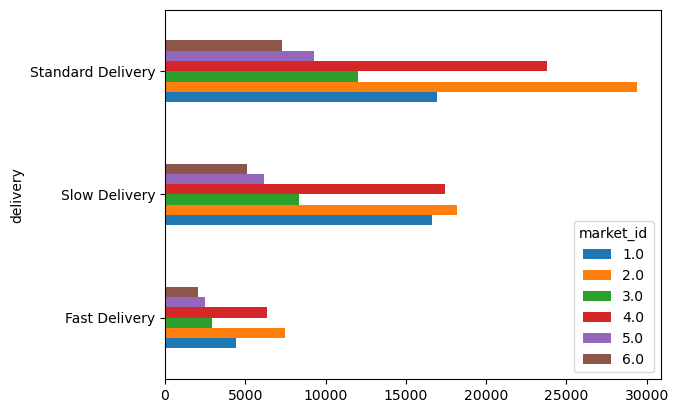

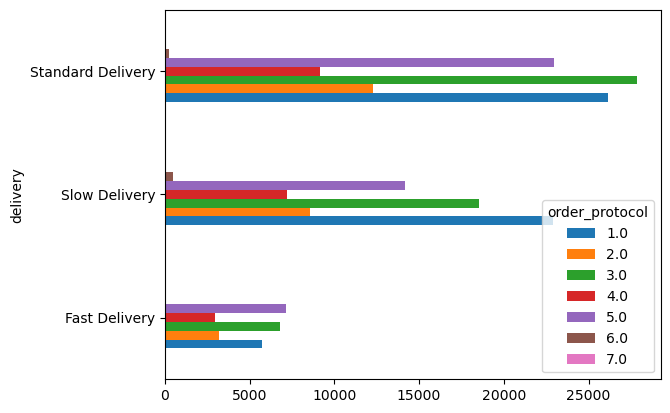

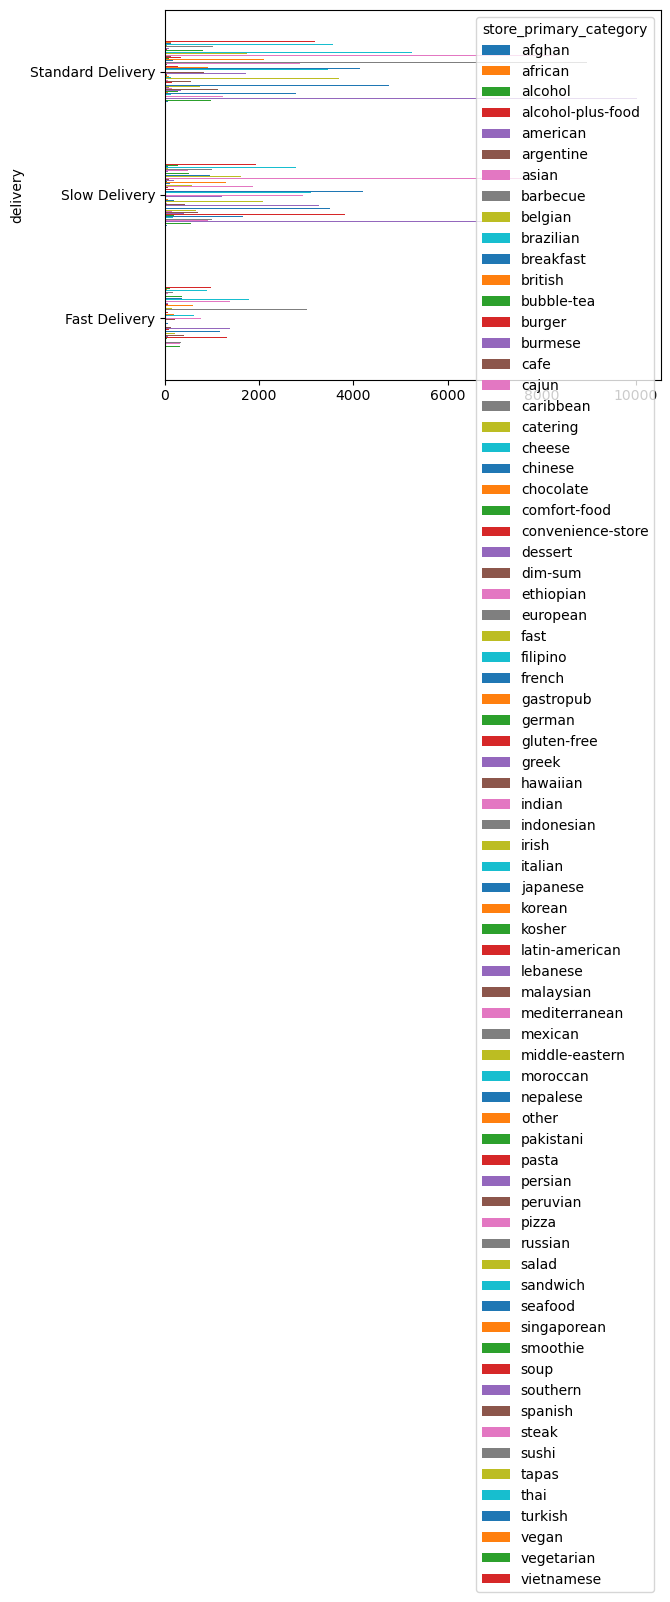

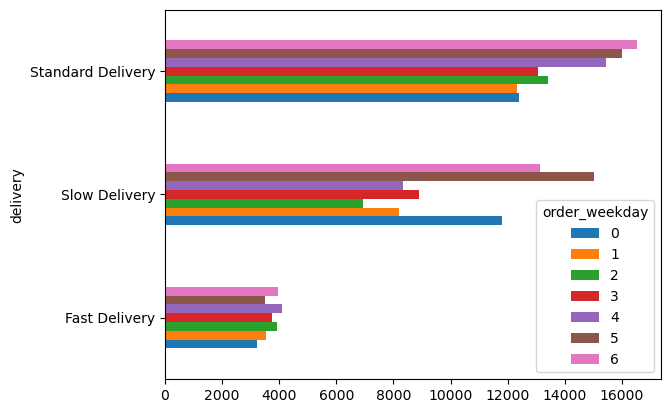

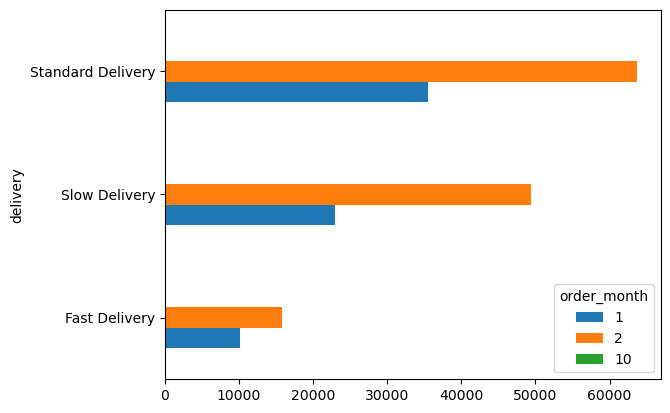

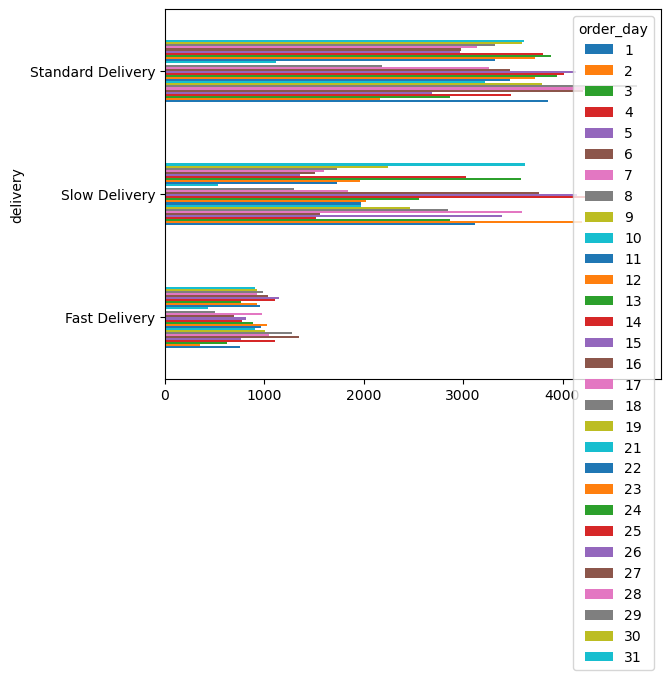

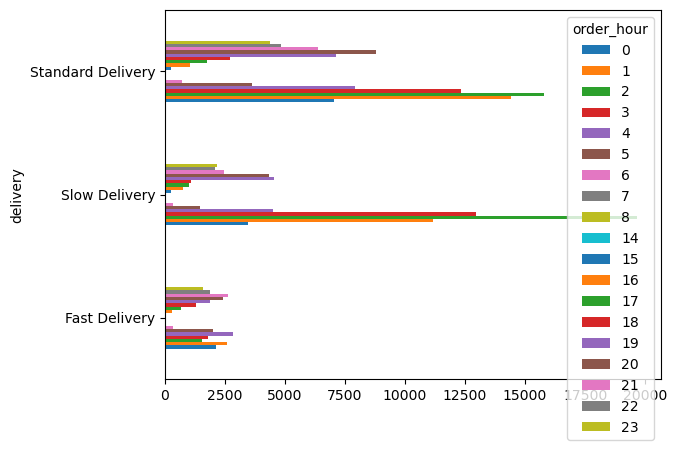

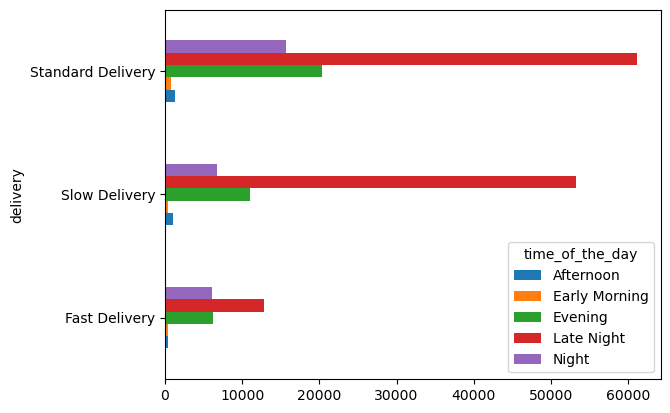

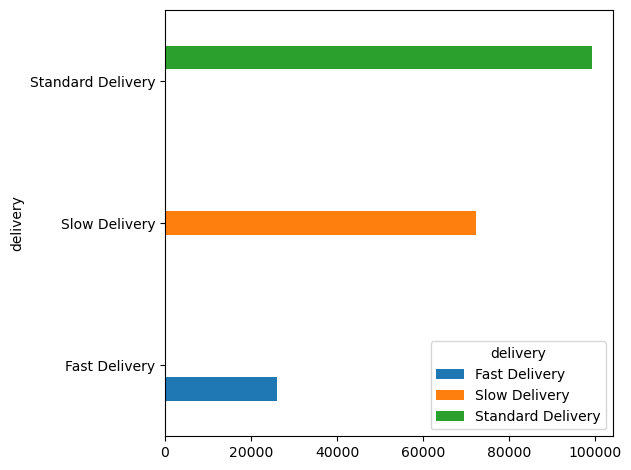

In [475]:
for i in cat_cols:
    pd.crosstab(index= data['delivery'], columns=data[i]).plot(kind='barh')
plt.tight_layout()
plt.show()

<AxesSubplot:>

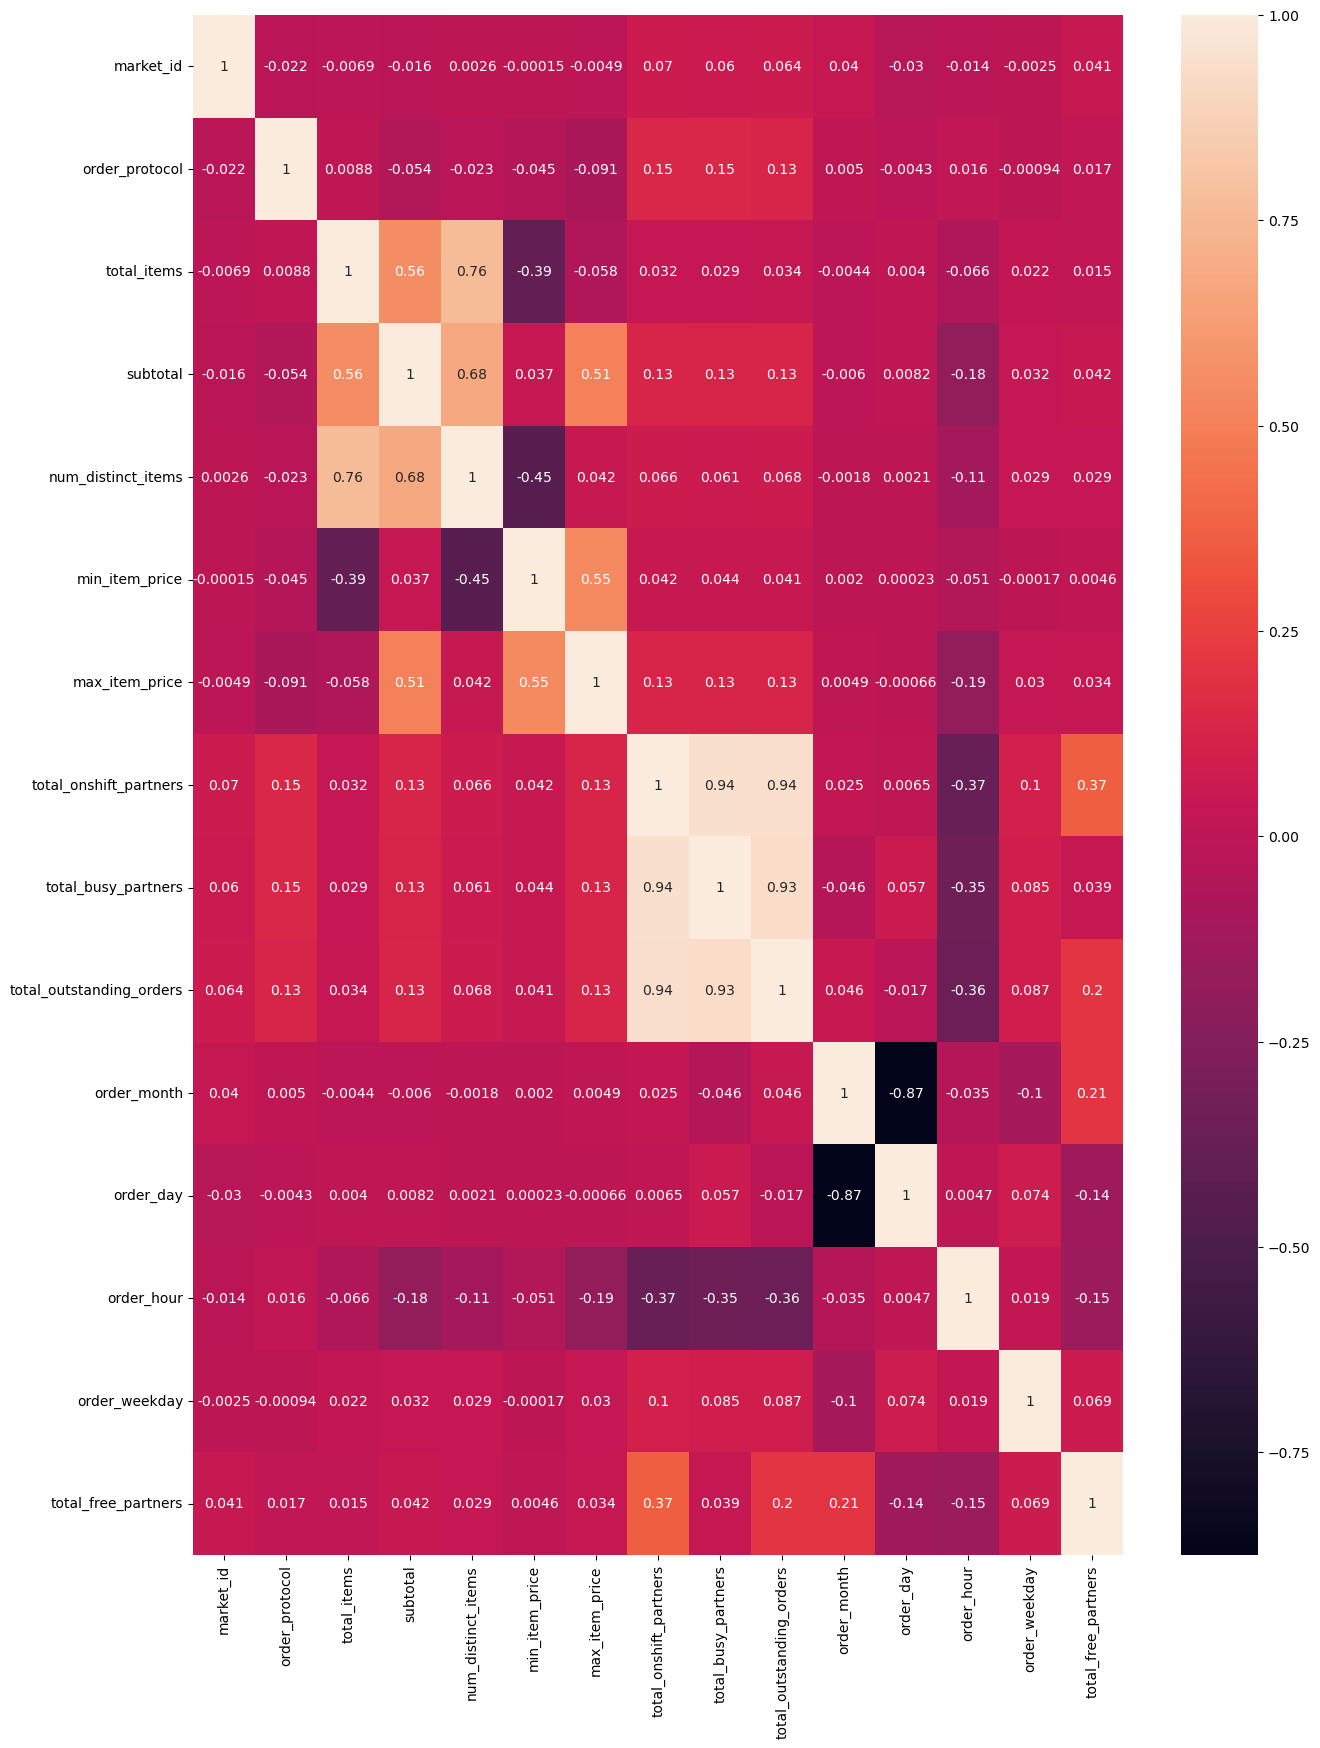

In [476]:
plt.figure(figsize= (15,20))
sns.heatmap(data.corr(), annot= True)

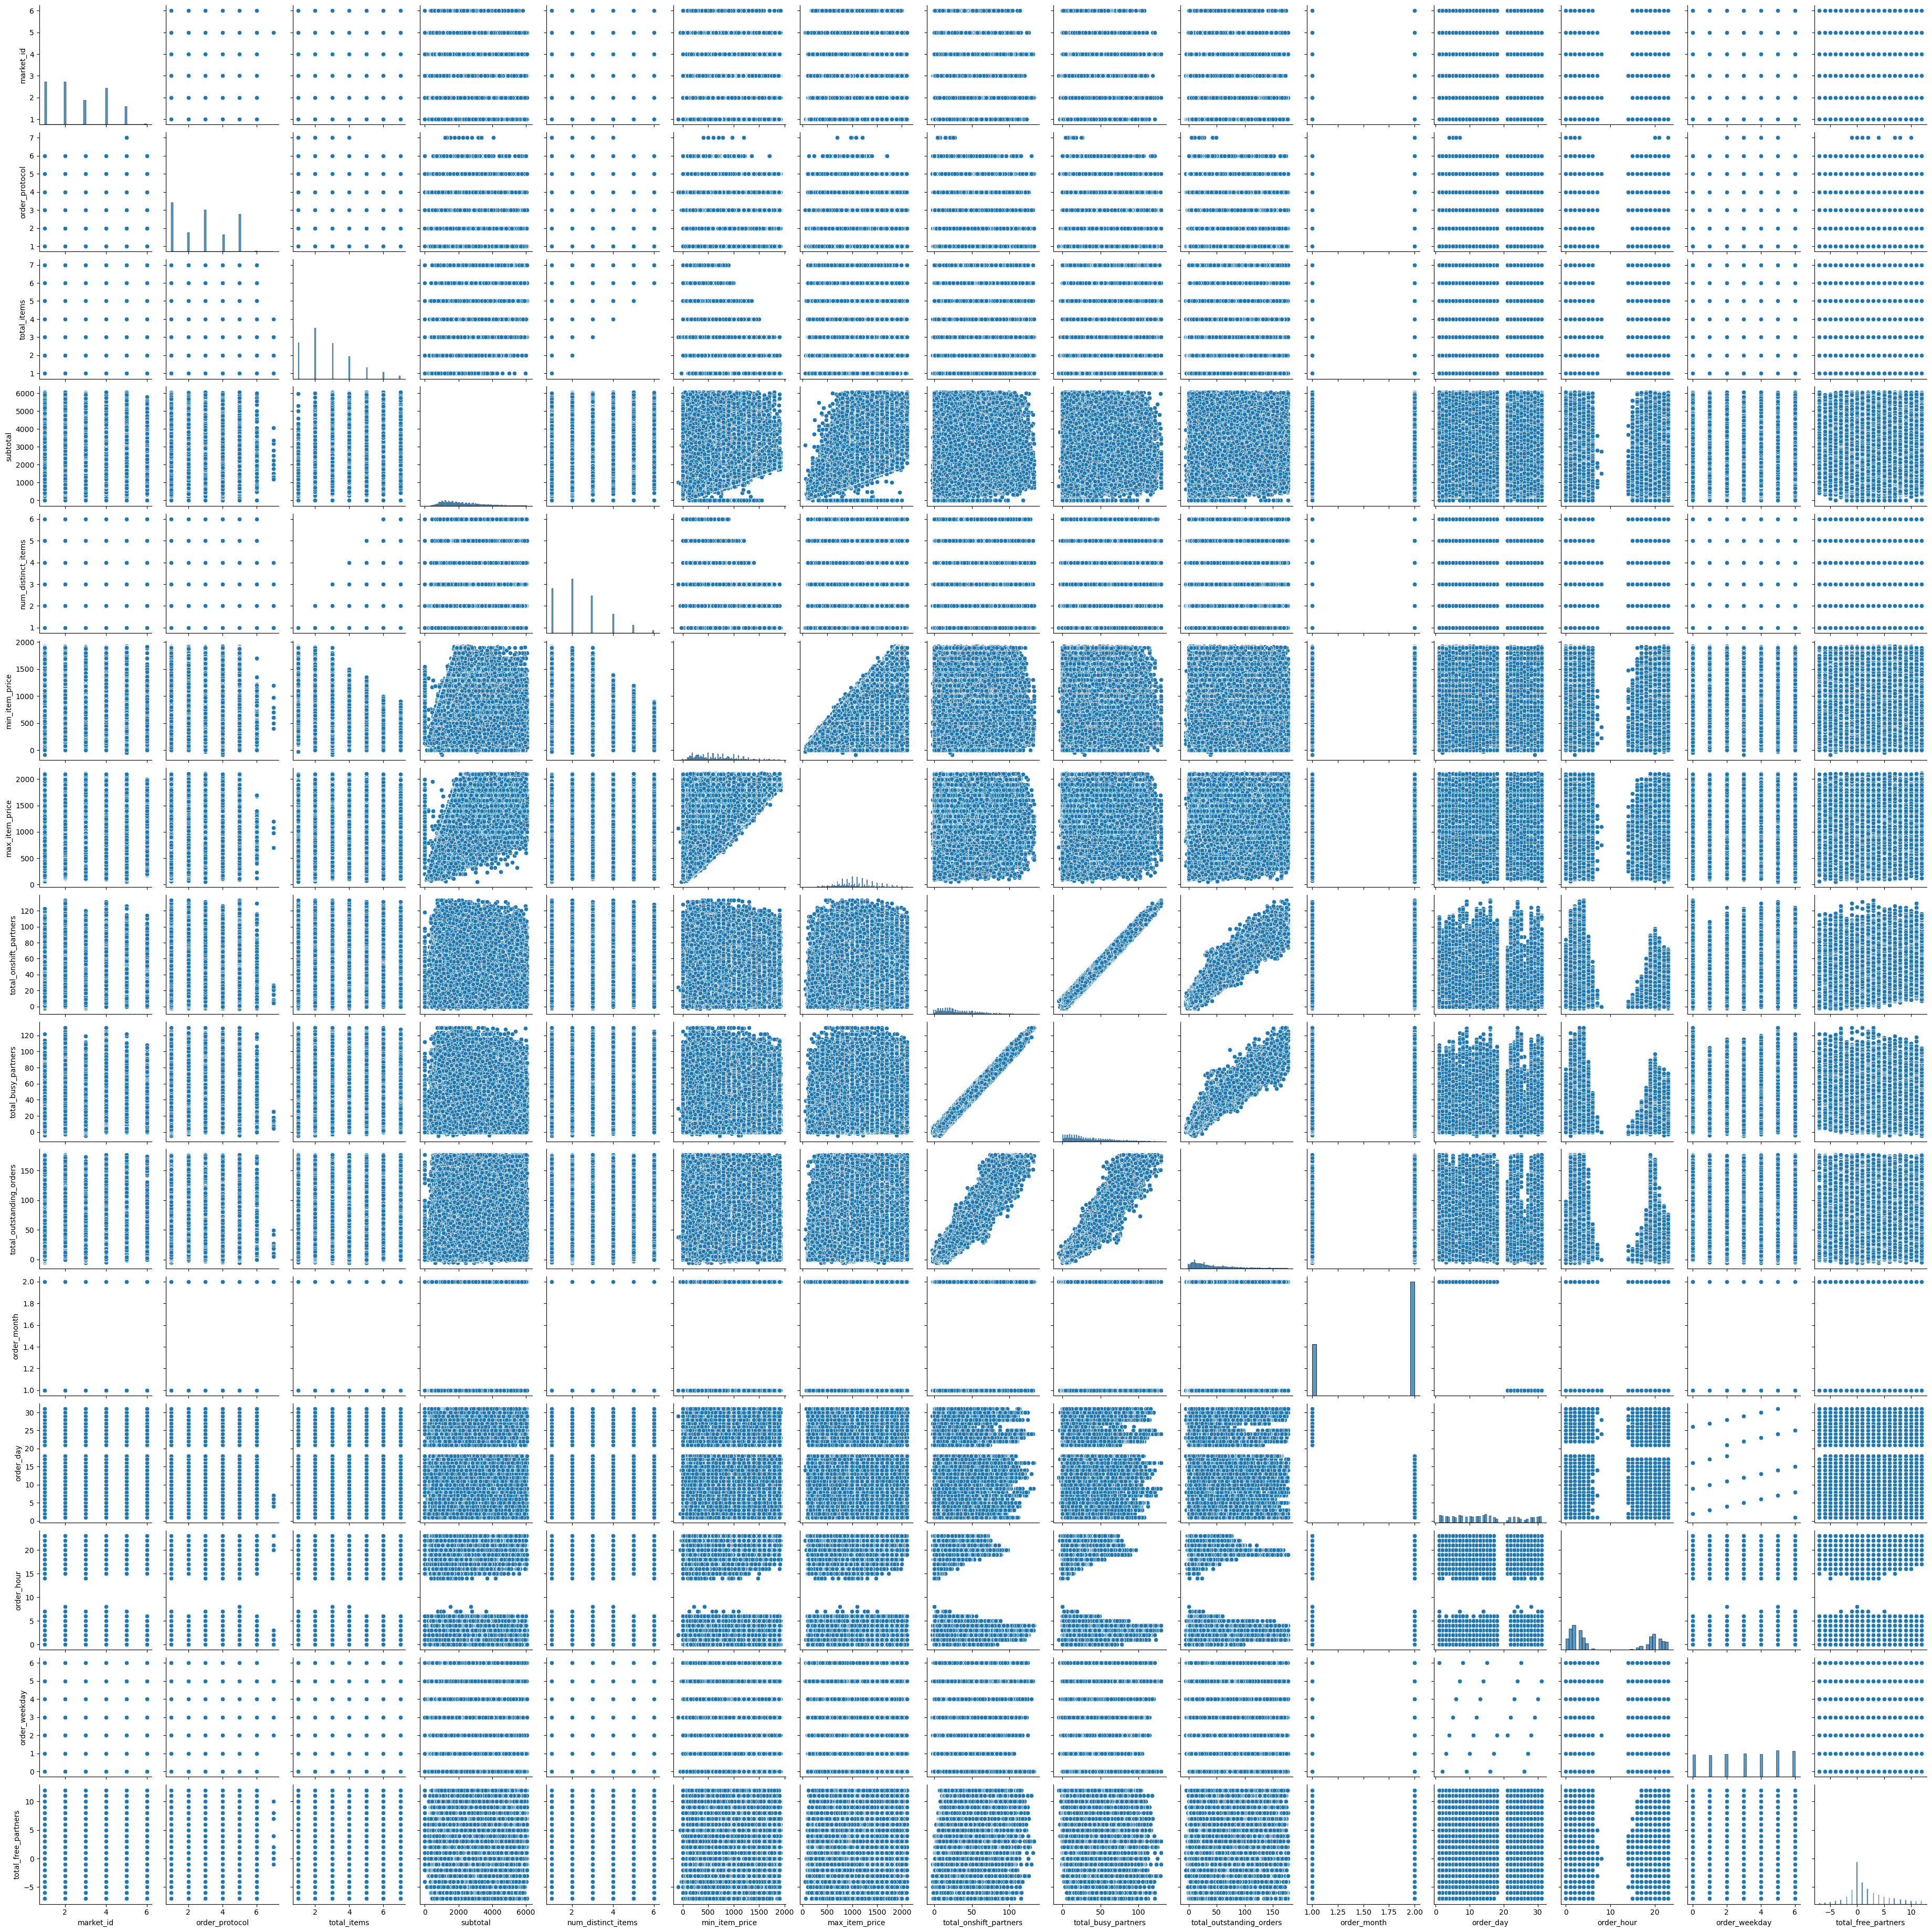

In [225]:
sns.pairplot(data)

# Missing Values 

In [477]:
# We saw that there was 1 category in order month that was 10 in our univariate analysis. let's check how many entries are 
# there.

In [478]:
data[data['order_month']==10]

market_id store_primary_category  order_protocol  total_items  subtotal  \
2690        1.0                italian             1.0            1      1695   

      num_distinct_items  min_item_price  max_item_price  \
2690                   1            1595            1595   

      total_onshift_partners  total_busy_partners  total_outstanding_orders  \
2690                     NaN                  NaN                       NaN   

           delivery  order_month  order_day  order_hour time_of_the_day  \
2690  Slow Delivery           10         19           5      Late Night   

      order_weekday  total_free_partners  
2690              6                  NaN

In [479]:
# Since there is only one entry that too has null values in many variables, we will drop this.
data.drop(index= 2690, inplace= True)

In [481]:
# percent of missing values in each variable.
(data.isnull().sum()/data.shape[0])

market_id                   0.004999
store_primary_category      0.024110
order_protocol              0.005040
total_items                 0.000000
subtotal                    0.000000
num_distinct_items          0.000000
min_item_price              0.000000
max_item_price              0.000000
total_onshift_partners      0.082365
total_busy_partners         0.082365
total_outstanding_orders    0.082365
delivery                    0.000000
order_month                 0.000000
order_day                   0.000000
order_hour                  0.000000
time_of_the_day             0.000000
order_weekday               0.000000
total_free_partners         0.082365
dtype: float64

In [482]:
# Since the null values accounts for 105 of the whole data, we will drop these because imputing with median or mode will create 
# unnecessary noise in the dataset.

In [483]:
data.dropna(inplace= True)

In [484]:
data.isnull().sum()

market_id                   0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
delivery                    0
order_month                 0
order_day                   0
order_hour                  0
time_of_the_day             0
order_weekday               0
total_free_partners         0
dtype: int64

In [485]:
# Number of unique values in store id where market id is nan.
# data[data['market_id'].isnull()]['store_id'].nunique()

In [487]:
# data.drop(index= data[data['market_id'].isnull()].index.to_list() ,inplace= True)

In [488]:
data.shape

(176255, 18)

# Outlier Treatment

In [489]:
for i in data.select_dtypes(include= np.number).columns:
    q1, q3= np.quantile(data[i], [0.25, 0.75])
    iqr= q3 - q1
    ll= q1 -1.5*iqr
    ul= q3 +1.5*iqr
    data= data[~((data[i] < ll) | (data[i]> ul))]

In [490]:
data.shape

(121644, 18)

In [491]:
data.reset_index(drop= True, inplace= True)

In [492]:
data.head()

market_id store_primary_category  order_protocol  total_items  subtotal  \
0        2.0                mexican             2.0            1      1900   
1        2.0                 indian             3.0            4      4771   
2        1.0                italian             1.0            1      1525   
3        1.0                italian             1.0            3      4475   
4        1.0                italian             1.0            3      4375   

   num_distinct_items  min_item_price  max_item_price  total_onshift_partners  \
0                   1            1400            1400                     1.0   
1                   3             820            1604                     8.0   
2                   1            1525            1525                     5.0   
3                   3             925            1825                     4.0   
4                   3            1325            1625                     6.0   

   total_busy_partners  total_outstanding_orders           delivery  \
0                  2.0                       2.0      Slow Delivery   
1                  6.0                      18.0      Fast Delivery   
2                  6.0                       8.0  Standard Delivery   
3                  1.0                       1.0      Slow Delivery   
4                  4.0                       3.0      Slow Delivery   

   order_month  order_day  order_hour time_of_the_day  order_weekday  \
0            2         10          21           Night              1   
1            2         16           0      Late Night              0   
2            2         12           3      Late Night              3   
3            2          6           0      Late Night              4   
4            2          8           2      Late Night              6   

   total_free_partners  
0                 -1.0  
1                  2.0  
2                 -1.0  
3                  3.0  
4                  2.0

# Scaling and Transformation

In [493]:
st= data['store_primary_category'].value_counts(normalize= True)
st

american             0.110018
mexican              0.091209
pizza                0.084213
burger               0.059937
sandwich             0.059058
                       ...   
moroccan             0.000058
russian              0.000049
belgian              0.000016
african              0.000008
alcohol-plus-food    0.000008
Name: store_primary_category, Length: 72, dtype: float64

Since there are 72 unique categories in store_primary_category, frequency encoding seems to be the good fit.

In [494]:
data['store_primary_category']= data['store_primary_category'].map(st.to_dict())

In [495]:
data.head()

market_id  store_primary_category  order_protocol  total_items  subtotal  \
0        2.0                0.091209             2.0            1      1900   
1        2.0                0.033919             3.0            4      4771   
2        1.0                0.032513             1.0            1      1525   
3        1.0                0.032513             1.0            3      4475   
4        1.0                0.032513             1.0            3      4375   

   num_distinct_items  min_item_price  max_item_price  total_onshift_partners  \
0                   1            1400            1400                     1.0   
1                   3             820            1604                     8.0   
2                   1            1525            1525                     5.0   
3                   3             925            1825                     4.0   
4                   3            1325            1625                     6.0   

   total_busy_partners  total_outstanding_orders           delivery  \
0                  2.0                       2.0      Slow Delivery   
1                  6.0                      18.0      Fast Delivery   
2                  6.0                       8.0  Standard Delivery   
3                  1.0                       1.0      Slow Delivery   
4                  4.0                       3.0      Slow Delivery   

   order_month  order_day  order_hour time_of_the_day  order_weekday  \
0            2         10          21           Night              1   
1            2         16           0      Late Night              0   
2            2         12           3      Late Night              3   
3            2          6           0      Late Night              4   
4            2          8           2      Late Night              6   

   total_free_partners  
0                 -1.0  
1                  2.0  
2                 -1.0  
3                  3.0  
4                  2.0

Since delivery is an ordinal variable, we will do manual encoding.

In [496]:
data['delivery']= data['delivery'].map({'Slow Delivery':1, 'Standard Delivery':2,'Fast Delivery':3})

In [497]:
data.head(5)

market_id  store_primary_category  order_protocol  total_items  subtotal  \
0        2.0                0.091209             2.0            1      1900   
1        2.0                0.033919             3.0            4      4771   
2        1.0                0.032513             1.0            1      1525   
3        1.0                0.032513             1.0            3      4475   
4        1.0                0.032513             1.0            3      4375   

   num_distinct_items  min_item_price  max_item_price  total_onshift_partners  \
0                   1            1400            1400                     1.0   
1                   3             820            1604                     8.0   
2                   1            1525            1525                     5.0   
3                   3             925            1825                     4.0   
4                   3            1325            1625                     6.0   

   total_busy_partners  total_outstanding_orders  delivery  order_month  \
0                  2.0                       2.0         1            2   
1                  6.0                      18.0         3            2   
2                  6.0                       8.0         2            2   
3                  1.0                       1.0         1            2   
4                  4.0                       3.0         1            2   

   order_day  order_hour time_of_the_day  order_weekday  total_free_partners  
0         10          21           Night              1                 -1.0  
1         16           0      Late Night              0                  2.0  
2         12           3      Late Night              3                 -1.0  
3          6           0      Late Night              4                  3.0  
4          8           2      Late Night              6                  2.0

In [498]:
data['time_of_the_day'].unique()

array(['Night', 'Late Night', 'Evening', 'Early Morning', 'Afternoon'],
      dtype=object)

time_of_the_day is  nominal and has only 4 categories,  creating dummy variables would be the best fit.

In [499]:
data= pd.get_dummies(data, drop_first= True)

In [500]:
data.head(5)

market_id  store_primary_category  order_protocol  total_items  subtotal  \
0        2.0                0.091209             2.0            1      1900   
1        2.0                0.033919             3.0            4      4771   
2        1.0                0.032513             1.0            1      1525   
3        1.0                0.032513             1.0            3      4475   
4        1.0                0.032513             1.0            3      4375   

   num_distinct_items  min_item_price  max_item_price  total_onshift_partners  \
0                   1            1400            1400                     1.0   
1                   3             820            1604                     8.0   
2                   1            1525            1525                     5.0   
3                   3             925            1825                     4.0   
4                   3            1325            1625                     6.0   

   total_busy_partners  total_outstanding_orders  delivery  order_month  \
0                  2.0                       2.0         1            2   
1                  6.0                      18.0         3            2   
2                  6.0                       8.0         2            2   
3                  1.0                       1.0         1            2   
4                  4.0                       3.0         1            2   

   order_day  order_hour  order_weekday  total_free_partners  \
0         10          21              1                 -1.0   
1         16           0              0                  2.0   
2         12           3              3                 -1.0   
3          6           0              4                  3.0   
4          8           2              6                  2.0   

   time_of_the_day_Early Morning  time_of_the_day_Evening  \
0                              0                        0   
1                              0                        0   
2                              0                        0   
3                              0                        0   
4                              0                        0   

   time_of_the_day_Late Night  time_of_the_day_Night  
0                           0                      1  
1                           1                      0  
2                           1                      0  
3                           1                      0  
4                           1                      0

Subtotal, min_item_price and max_item_price has large values as compared to the other variables, we need to bring these to the same scale as others and hence will scale these variables.

In [501]:
cols= ['subtotal','min_item_price','max_item_price','total_onshift_partners', 'total_busy_partners','total_outstanding_orders',
      'total_free_partners']
sc= StandardScaler()

for i in cols:
    data[i]= sc.fit_transform(pd.DataFrame(data[i]))

In [502]:
del data['total_free_partners']

In [503]:
del data['order_hour']

In [504]:
data.head()

market_id  store_primary_category  order_protocol  total_items  subtotal  \
0        2.0                0.091209             2.0            1 -0.287667   
1        2.0                0.033919             3.0            4  2.107161   
2        1.0                0.032513             1.0            1 -0.600471   
3        1.0                0.032513             1.0            3  1.860254   
4        1.0                0.032513             1.0            3  1.776840   

   num_distinct_items  min_item_price  max_item_price  total_onshift_partners  \
0                   1        1.858113        0.930389               -1.265436   
1                   3        0.419451        1.470935               -1.004115   
2                   1        2.168169        1.261606               -1.116110   
3                   3        0.679899        2.056527               -1.153441   
4                   3        1.672079        1.526579               -1.078778   

   total_busy_partners  total_outstanding_orders  delivery  order_month  \
0            -1.185145                 -1.048941         1            2   
1            -1.032090                 -0.662734         3            2   
2            -1.032090                 -0.904113         2            2   
3            -1.223408                 -1.073079         1            2   
4            -1.108618                 -1.024803         1            2   

   order_day  order_weekday  time_of_the_day_Early Morning  \
0         10              1                              0   
1         16              0                              0   
2         12              3                              0   
3          6              4                              0   
4          8              6                              0   

   time_of_the_day_Evening  time_of_the_day_Late Night  time_of_the_day_Night  
0                        0                           0                      1  
1                        0                           1                      0  
2                        0                           1                      0  
3                        0                           1                      0  
4                        0                           1                      0

# Train Test Split

In [505]:
X= data.drop(columns= 'delivery', axis=1)
y= data['delivery']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.3)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (85150, 18)
y_train (85150,)
X_test (36494, 18)
y_test (36494,)


# Logistic Regression Model

In [506]:
logreg= LogisticRegression(random_state= 10, n_jobs= -1)
logreg.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=10)

In [507]:
y_pred_train= logreg.predict(X_train)
y_pred_test= logreg.predict(X_test)

In [508]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           1       0.61      0.42      0.50     29556
           2       0.56      0.83      0.67     43393
           3       0.44      0.01      0.01     12201

    accuracy                           0.57     85150
   macro avg       0.53      0.42      0.39     85150
weighted avg       0.56      0.57      0.51     85150



In [509]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.60      0.42      0.49     12583
           2       0.56      0.83      0.67     18699
           3       0.45      0.01      0.01      5212

    accuracy                           0.57     36494
   macro avg       0.54      0.42      0.39     36494
weighted avg       0.56      0.57      0.51     36494



In [511]:
cohen_kappa_score(y_test, y_pred_test)

0.18666277110006801

In [512]:
logreg.intercept_

array([ 0.06984317,  0.20422962, -0.27407279])

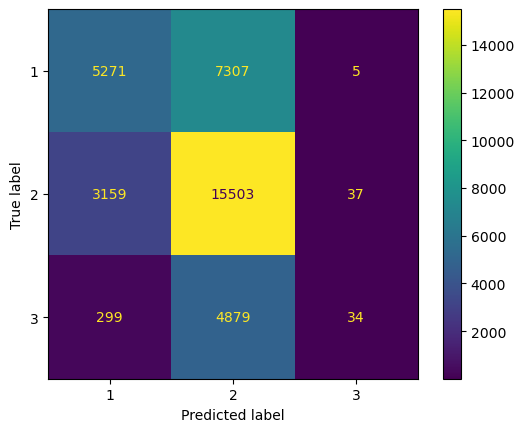

In [513]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

In [515]:
# consider the independent variables (without the intercept term)
X_train_rfe = X_train.iloc[:,1:]
X_test_rfe = X_test.iloc[:,1:]

logreg = LogisticRegression()

rfe_model = RFE(estimator = logreg, n_features_to_select = 5)
rfe_model = rfe_model.fit(X_train_rfe, y_train)

feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)
signi_feat_rfe = feat_index[feat_index==1].index

print(feat_index)
print(signi_feat_rfe)

store_primary_category            3
order_protocol                    6
total_items                      11
subtotal                          2
num_distinct_items                8
min_item_price                   12
max_item_price                    9
total_onshift_partners            1
total_busy_partners               4
total_outstanding_orders          1
order_month                       7
order_day                        13
order_weekday                    10
time_of_the_day_Early Morning     1
time_of_the_day_Evening           1
time_of_the_day_Late Night        5
time_of_the_day_Night             1
dtype: int32
Index(['total_onshift_partners', 'total_outstanding_orders',
       'time_of_the_day_Early Morning', 'time_of_the_day_Evening',
       'time_of_the_day_Night'],
      dtype='object')


In [519]:
logreg= LogisticRegression(random_state= 10, n_jobs= -1)

logreg.fit(X_train[['total_onshift_partners', 'total_outstanding_orders',
       'time_of_the_day_Early Morning', 'time_of_the_day_Evening',
       'time_of_the_day_Night']], y_train)

y_pred_test= logreg.predict(X_test[['total_onshift_partners', 'total_outstanding_orders',
       'time_of_the_day_Early Morning', 'time_of_the_day_Evening',
       'time_of_the_day_Night']])

In [520]:
 print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.60      0.39      0.47     12583
           2       0.56      0.84      0.67     18699
           3       0.37      0.00      0.01      5212

    accuracy                           0.57     36494
   macro avg       0.51      0.41      0.38     36494
weighted avg       0.54      0.57      0.51     36494



# Decision Tree

In [144]:
decision_tree= DecisionTreeClassifier(criterion= 'entropy', random_state= 10)
decision_tree.fit(X_train, y_train)

y_pred_train= decision_tree.predict(X_train)
y_pred_test= decision_tree.predict(X_test)

In [145]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     29556
           2       1.00      1.00      1.00     32747
           3       1.00      1.00      1.00     22835
           4       1.00      1.00      1.00        12

    accuracy                           1.00     85150
   macro avg       1.00      1.00      1.00     85150
weighted avg       1.00      1.00      1.00     85150



In [146]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.46      0.47      0.47     12583
           2       0.41      0.40      0.41     14210
           3       0.37      0.37      0.37      9695
           4       0.00      0.00      0.00         6

    accuracy                           0.42     36494
   macro avg       0.31      0.31      0.31     36494
weighted avg       0.42      0.42      0.42     36494



In [147]:
# Tuning Hyperparameters using gridsearchcv
tuned_params= {'criterion': ['entropy', 'gini'], 'max_depth': range(2,10),
              'max_features': ['sqrt','log2'], 'min_samples_split': range(2,10),
              'min_samples_leaf': range(1,10), 'max_leaf_nodes': range(1,10)}

decision_tree= DecisionTreeClassifier(random_state= 10)

tree_grid= GridSearchCV(estimator= decision_tree, param_grid= tuned_params, cv= 5, n_jobs= -1)

tree_grid_model= tree_grid.fit(X_train, y_train)

print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_)

Best parameters for decision tree classifier:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [148]:
# Fitting the final model based on the best parameters that we got from gridsearchcv
dt_model = DecisionTreeClassifier(criterion = tree_grid_model.best_params_.get('criterion'),
                                  max_depth = tree_grid_model.best_params_.get('max_depth'),
                                  max_features = tree_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = tree_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = tree_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = tree_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

# use fit() to fit the model on the train set
dt_model = dt_model.fit(X_train, y_train)

y_pred_train= dt_model.predict(X_train)
y_pred_test= dt_model.predict(X_test)

In [149]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           1       0.46      0.55      0.50     29556
           2       0.40      0.61      0.48     32747
           3       0.00      0.00      0.00     22835
           4       0.00      0.00      0.00        12

    accuracy                           0.42     85150
   macro avg       0.21      0.29      0.25     85150
weighted avg       0.31      0.42      0.36     85150



In [150]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.46      0.55      0.50     12583
           2       0.40      0.61      0.48     14210
           3       0.00      0.00      0.00      9695
           4       0.00      0.00      0.00         6

    accuracy                           0.43     36494
   macro avg       0.22      0.29      0.25     36494
weighted avg       0.31      0.43      0.36     36494



# Random Forest

In [151]:
rf_classification = RandomForestClassifier(n_estimators = 10, random_state = 10)

rf_model = rf_classification.fit(X_train, y_train)

y_pred_train= rf_model.predict(X_train)
y_pred_test= rf_model.predict(X_test)

In [152]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           1       0.98      0.99      0.99     29556
           2       0.98      0.98      0.98     32747
           3       0.99      0.98      0.98     22835
           4       1.00      1.00      1.00        12

    accuracy                           0.99     85150
   macro avg       0.99      0.99      0.99     85150
weighted avg       0.99      0.99      0.99     85150



In [153]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.50      0.55      0.52     12583
           2       0.43      0.46      0.44     14210
           3       0.44      0.33      0.38      9695
           4       0.00      0.00      0.00         6

    accuracy                           0.46     36494
   macro avg       0.34      0.34      0.34     36494
weighted avg       0.45      0.46      0.45     36494



In [154]:
tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [10, 30, 50, 70, 90],
                     'max_depth': [10, 15, 20],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2, 5, 8, 11],
                     'min_samples_leaf': [1, 5, 9],
                     'max_leaf_nodes': [2, 5, 8, 11]}]
 
random_forest_classification = RandomForestClassifier(random_state = 10)

rf_grid = GridSearchCV(estimator = random_forest_classification, 
                       param_grid = tuned_paramaters, 
                       cv = 5, n_jobs= -1)

# use fit() to fit the model on the train set
rf_grid_model = rf_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for random forest classifier: ', rf_grid_model.best_params_)

Best parameters for random forest classifier:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


In [155]:
rf_model = RandomForestClassifier(criterion = rf_grid_model.best_params_.get('criterion'), 
                                  n_estimators = rf_grid_model.best_params_.get('n_estimators'),
                                  max_depth = rf_grid_model.best_params_.get('max_depth'),
                                  max_features = rf_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = rf_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = rf_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = rf_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10, n_jobs= -1)

rf_model = rf_model.fit(X_train, y_train)

y_pred_test= rf_model.predict(X_test)

print('Classification Report for test set:\n', classification_report(y_test, y_pred_test))

Classification Report for test set:
               precision    recall  f1-score   support

           1       0.49      0.50      0.49     12583
           2       0.41      0.68      0.51     14210
           3       0.65      0.00      0.01      9695
           4       0.00      0.00      0.00         6

    accuracy                           0.44     36494
   macro avg       0.39      0.29      0.25     36494
weighted avg       0.50      0.44      0.37     36494

